<a href="https://colab.research.google.com/github/Amrutharh/Future-interns-projects/blob/main/ai_powered_sales_forecasting_dashboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
1.load data and inspect data

In [17]:
import pandas as pd

df = pd.read_csv('/content/retail_store_inventory.csv')

print("DataFrame Head:")
print(df.head())

print("\nDataFrame Info:")
df.info()

print("\nDataFrame Description:")
print(df.describe())

DataFrame Head:
         Date Store ID Product ID     Category Region  Inventory Level  \
0  2022-01-01     S001      P0001    Groceries  North              231   
1  2022-01-01     S001      P0002         Toys  South              204   
2  2022-01-01     S001      P0003         Toys   West              102   
3  2022-01-01     S001      P0004         Toys  North              469   
4  2022-01-01     S001      P0005  Electronics   East              166   

   Units Sold  Units Ordered  Demand Forecast  Price  Discount  \
0         127             55           135.47  33.50        20   
1         150             66           144.04  63.01        20   
2          65             51            74.02  27.99        10   
3          61            164            62.18  32.72        10   
4          14            135             9.26  73.64         0   

  Weather Condition  Holiday/Promotion  Competitor Pricing Seasonality  
0             Rainy                  0               29.69      Autum

2. perform EDA and initial visulaization

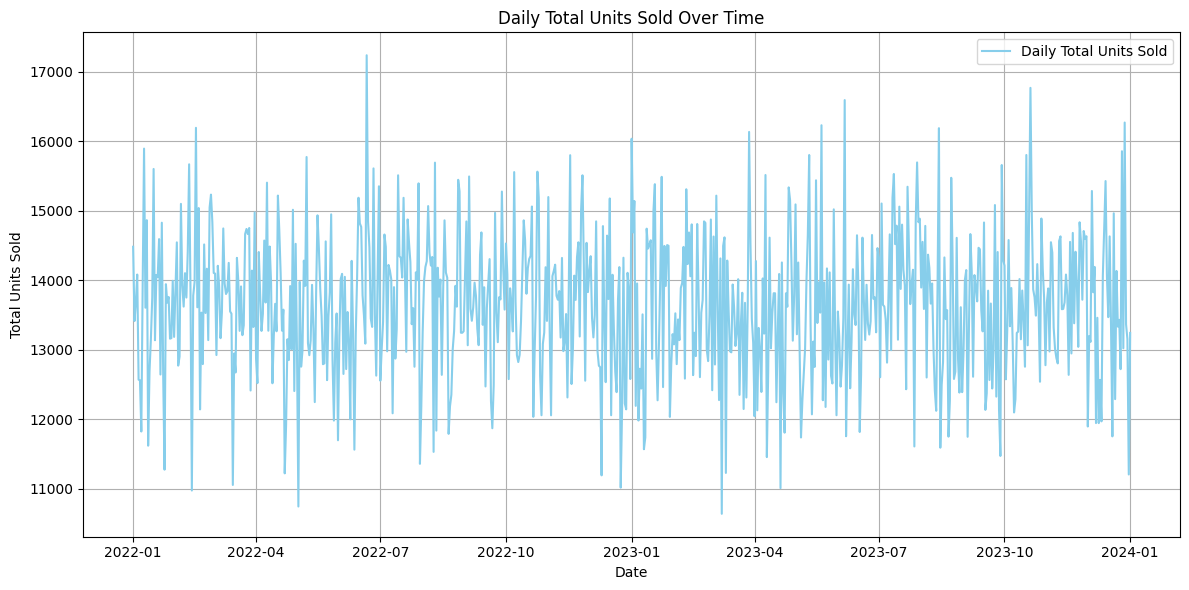

In [18]:
import matplotlib.pyplot as plt

df['Date'] = pd.to_datetime(df['Date'])

daily_sales = df.groupby('Date')['Units Sold'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(daily_sales['Date'], daily_sales['Units Sold'], label='Daily Total Units Sold', color='skyblue')
plt.title('Daily Total Units Sold Over Time')
plt.xlabel('Date')
plt.ylabel('Total Units Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

3. preprocess data for prophet model

In [19]:
daily_sales_prophet = daily_sales.rename(columns={'Date': 'ds', 'Units Sold': 'y'})

print("DataFrame for Prophet Model (daily_sales_prophet):")
print(daily_sales_prophet.head())

DataFrame for Prophet Model (daily_sales_prophet):
          ds      y
0 2022-01-01  14484
1 2022-01-02  13415
2 2022-01-03  13681
3 2022-01-04  14084
4 2022-01-05  12572


4. train prophet model and generate forecast

In [20]:
# Reinstall prophet to ensure all dependencies are correctly handled
!pip install prophet

from prophet import Prophet

# Initialize the Prophet model
model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True)

# Fit the model to the daily_sales_prophet DataFrame
model.fit(daily_sales_prophet)

# Create a DataFrame for future dates (e.g., 365 days into the future)
future = model.make_future_dataframe(periods=365, freq='D')

# Generate predictions for these future dates
forecast = model.predict(future)

print("Prophet model re-initialized, trained, and forecast generated successfully.")
print("First 5 rows of the forecast dataframe:")
print(forecast.head())

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Prophet model re-initialized, trained, and forecast generated successfully.
First 5 rows of the forecast dataframe:
          ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2022-01-01  13736.884221  12161.076489  14652.341645  13736.884221   
1 2022-01-02  13736.584963  12388.672289  14999.532513  13736.584963   
2 2022-01-03  13736.285706  12129.375204  14710.370213  13736.285706   
3 2022-01-04  13735.986448  12369.711432  14995.215395  13735.986448   
4 2022-01-05  13735.687191  12390.643170  14920.484690  13735.687191   

    trend_upper  multiplicative_terms  multiplicative_terms_lower  \
0  13736.884221             -0.020617                   -0.020617   
1  13736.584963             -0.008710                   -0.008710   
2  13736.285706             -0.020415                   -0.020415   
3  13735.986448             -0.003471                   -0.003471   
4  13735.687191             -0.007775                   -0.007775   

   multiplicative_terms_upper    wee

5. evaluate model performance (RMSLE)

In [21]:
import numpy as np

# Merge actuals with forecast for evaluation
eval_df = pd.merge(daily_sales_prophet, forecast[['ds', 'yhat']], on='ds', how='inner')

# Ensure no negative values before taking logarithm
eval_df['yhat'] = eval_df['yhat'].apply(lambda x: max(x, 0))

# Calculate RMSLE
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

rmsle_score = rmsle(eval_df['y'], eval_df['yhat'])

print(f"RMSLE: {rmsle_score:.4f}")

RMSLE: 0.0741


6.visualize prophet model results

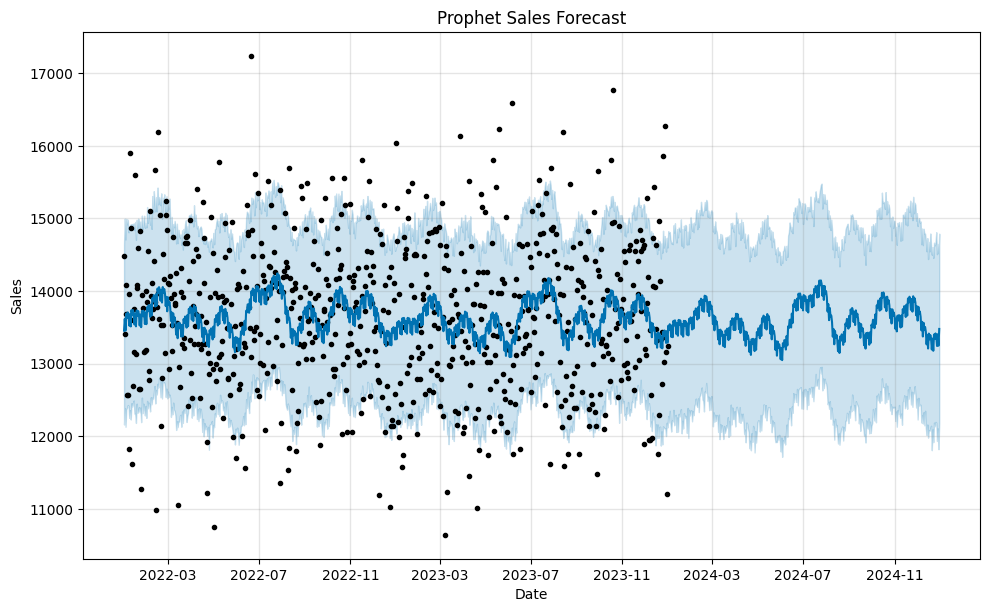

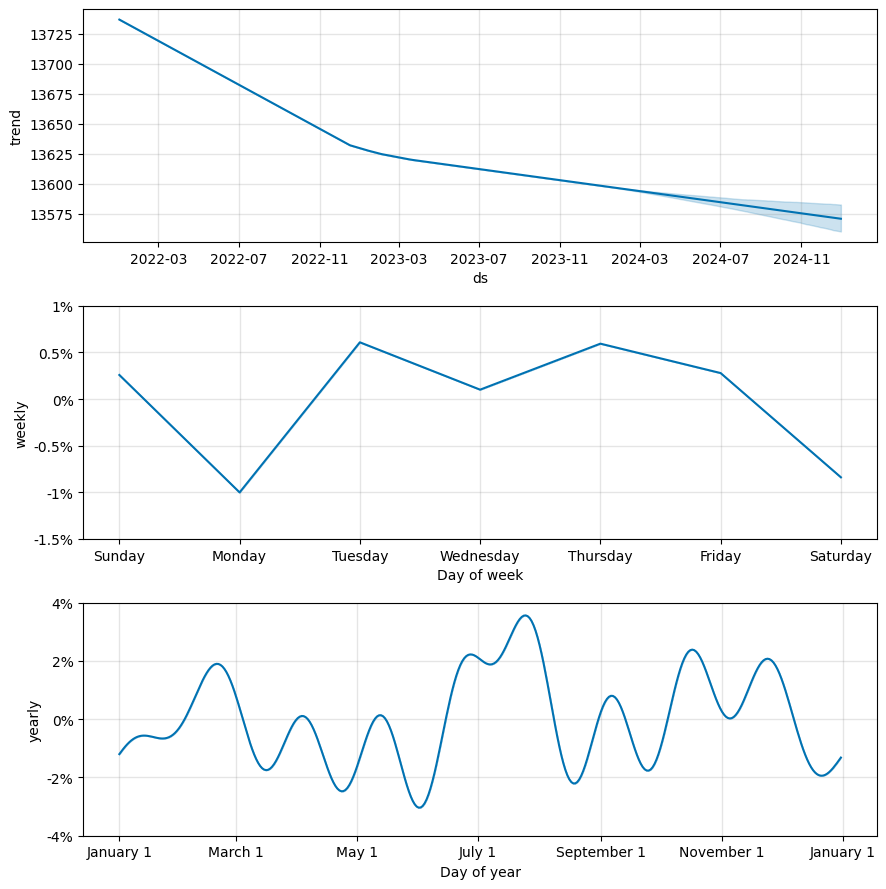

In [22]:
import matplotlib.pyplot as plt

# Visualize the forecast
fig1 = model.plot(forecast)
plt.title("Prophet Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

# Visualize the forecast components (trend, weekly, yearly seasonality)
fig2 = model.plot_components(forecast)
plt.show()